In [6]:
import datetime
import numpy as np
import pandas as pd
import cv2
from copy import deepcopy
from tqdm import tqdm

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard, ModelCheckpoint, LambdaCallback
from keras import backend as K
from keras.utils import Sequence
from keras_tqdm import TQDMNotebookCallback
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from IPython.display import clear_output
import keras

from libs.pconv_model import PConvUnet
from libs.util import MaskGenerator, AugmentingDataGenerator

In [10]:
get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')
plt.ioff()

# SETTINGS
TRAIN_DIR = './data/train'
VAL_DIR = './data/val'
TEST_DIR = './data/test_samples'

BATCH_SIZE = 4

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
train_datagen = AugmentingDataGenerator(rotation_range=10,width_shift_range=0.1,height_shift_range=0.1,rescale=1./255,
                horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(TRAIN_DIR, MaskGenerator(512, 512, 3),target_size=(512, 512), 
                batch_size=BATCH_SIZE)


val_datagen = AugmentingDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(VAL_DIR, MaskGenerator(512, 512, 3), target_size=(512, 512), 
                batch_size=BATCH_SIZE, seed=42)


test_datagen = AugmentingDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(TEST_DIR, MaskGenerator(512, 512, 3), target_size=(512, 512), 
                batch_size=BATCH_SIZE, seed=64)

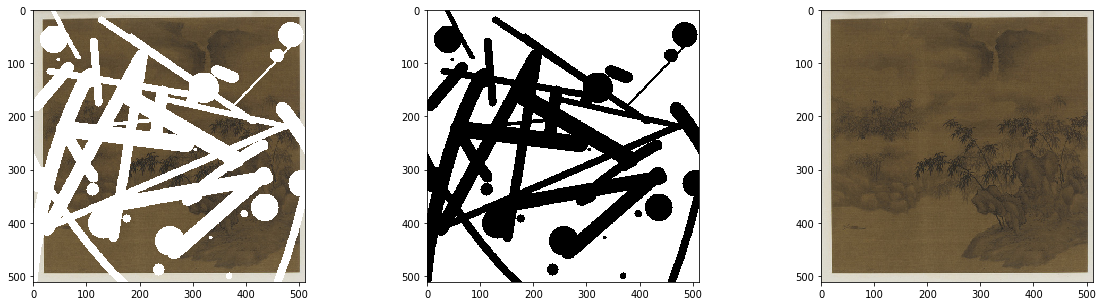

In [18]:
test_data = next(test_generator)
(masked, mask), ori = test_data
for i in range(len(ori)):
    _, axes = plt.subplots(1, 3, figsize=(20, 5))
    axes[0].imshow(masked[i,:,:,:])
    axes[1].imshow(mask[i,:,:,:] * 1.)
    axes[2].imshow(ori[i,:,:,:])
    plt.show()


In [20]:
model = PConvUnet(vgg_weights='/Users/wei-rulin/Desktop/UCSD/21Spring/ECE285/Final project/report/Project/pytorch_to_keras_vgg16.h5')


In [23]:
model.load('/Users/wei-rulin/Desktop/UCSD/21Spring/ECE285/Final project/report/Project/pconv_imagenet.26-1.07.h5',train_bn=True,lr=0.00005)


In [24]:
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()



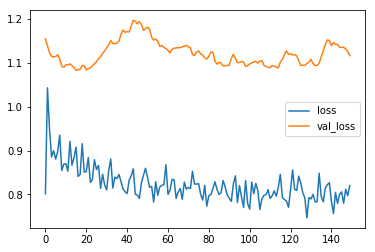

In [26]:
model.fit_generator(train_generator, steps_per_epoch=5, validation_data=val_generator,validation_steps=1,epochs=150,verbose=0,
    callbacks=[TensorBoard(log_dir='./data/logs/imagenet_phase2',write_graph=False),
    ModelCheckpoint('./data/logs/imagenet_phase2/weights.{epoch:02d}-{loss:.2f}.h5',monitor='val_loss', save_best_only=True, save_weights_only=True),
    plot_losses,
    TQDMNotebookCallback()])

In [27]:
model_tuned = PConvUnet()
model_tuned.load("/Users/wei-rulin/Desktop/UCSD/21Spring/ECE285/Final project/report/Project/data/logs/imagenet_phase2/weights.03-0.95.h5",train_bn=False,lr=0.00005)

model_prev = PConvUnet(vgg_weights='/Users/wei-rulin/Desktop/UCSD/21Spring/ECE285/Final project/report/Project/pytorch_to_keras_vgg16.h5')
model_prev.load('/Users/wei-rulin/Desktop/UCSD/21Spring/ECE285/Final project/report/Project/pconv_imagenet.26-1.07.h5',train_bn=False,lr=0.00005)

In [28]:
n = 0
for (masked, mask), ori in tqdm(test_generator):
    
    pred_img_tuned = model_tuned.predict([masked, mask])
    pred_img_prev = model_prev.predict([masked, mask])
    time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
    for i in range(len(ori)):
        _, axes = plt.subplots(1, 4, figsize=(20, 5))
        
        axes[0].imshow(masked[i,:,:,:])
        axes[1].imshow(pred_img_prev[i,:,:,:] * 1.)
        axes[2].imshow(pred_img_tuned[i,:,:,:] * 1.)
        axes[3].imshow(ori[i,:,:,:])
        axes[0].set_title('Masked Image')
        axes[1].set_title('Before Fine Tune')
        axes[2].set_title('After Fine Tune')
        axes[3].set_title('Ground Truth')
        axes[0].xaxis.set_major_formatter(NullFormatter())
        axes[0].yaxis.set_major_formatter(NullFormatter())
        axes[1].xaxis.set_major_formatter(NullFormatter())
        axes[1].yaxis.set_major_formatter(NullFormatter())
        axes[2].xaxis.set_major_formatter(NullFormatter())
        axes[2].yaxis.set_major_formatter(NullFormatter())
        axes[3].xaxis.set_major_formatter(NullFormatter())
        axes[3].yaxis.set_major_formatter(NullFormatter())
        plt.savefig(r'data/test_samples/1img_{}_{}.png'.format(i, time))
        plt.close()
        n += 1
        
    # Only create predictions for about 100 images
    if n > 100:
        break
        


100it [09:19,  5.38s/it]